In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import numpy as np
import scipy
import glob
import sys
from scipy import io
import math
import random
import keras
from sklearn import preprocessing
import tqdm

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# GLOBALS

In [2]:
POET_DIR = "D:/data/POETdataset/"
PATCHES_FILE = os.path.join(POET_DIR, "all_patches_list.npy")
LABELS_FILE = os.path.join(POET_DIR, "all_labels_list.npy")
pascal_images = os.path.join(POET_DIR, 'PascalImages')
CLASS2IDX_FILE = os.path.join(POET_DIR, 'class2idx.npy')
IDX2CLASS_FILE = os.path.join(POET_DIR, 'idx2class.npy')
PATCH_SIZE = 32
HALF_PATCH = PATCH_SIZE//2
DATASET_SIZE = 6270
VALIDATION_PERC = 0.2
MAX_GAZE_POINTS = 3 # TEMPORARY
MIN_GAZE_POINTS = 3
VGG_NR_FEATURES = 512
user_index = 0 # TEMPORARY
BATCH_SIZE = 50
os.chdir(POET_DIR)

In [3]:
os.chdir(POET_DIR)

# PATCH EXTRACTION 

In [4]:
classes = [a.split("_")[1].split(".mat")[0] for a in glob.glob("etData/*")]
idx2class = {i:c for i, c in enumerate(classes)}
class2idx = {c:i for i, c in enumerate(classes)}

In [5]:
def fixation_within_image(fx, fy, dims):
#   print(dims)
  if fx < 0:
    return False
  if fx > dims[0]:
    return False
  if fy < 0:
    return False
  if fy > dims[1]:
    return False

  return True

In [6]:
def get_avg_fixations(fixR, fixL, dims):
    # ger average of fixations between right and left eye
    fix = []
    for i in range(len(fixR)):
        fR = fixR[i]
        fL = fixL[i]
        fx = None
        fy = None
        # no fixations outside
        if np.isnan(fR[0]):
            fx = fL[0]
            fy = fL[1]
        elif np.isnan(fL[0]):
            fx = fR[0]
            fy = fR[1]
        else:
            fx = np.mean([fR[0],fL[0]])
            fy = np.mean([fR[1],fL[1]])
        if fixation_within_image(fx, fy, dims):
            fix.append([fx,fy])

    fix = np.array(fix)
    return fix[:MAX_GAZE_POINTS]

In [7]:
def get_fixations(filename, classname, dims):
    filename = filename.split("%s_" %classname)[1]
    filename = filename.split('.')[0]
    c_instances = io.loadmat(os.path.join(POET_DIR,'etData','etData_%s.mat' %classname), squeeze_me=True)['etData']
    user_index = 1
    for i in c_instances:
        if filename == i['filename']:
            fixR = i['fixations'][user_index]['imgCoord']['fixR'].tolist()['pos'].tolist()
            fixL = i['fixations'][user_index]['imgCoord']['fixL'].tolist()['pos'].tolist()
            if len(fixL.shape) < 2:
                return None
            fix = get_avg_fixations(fixR, fixL, dims)
            return fix


In [12]:
def gen_patches(filename, classname):
    img_src = keras.preprocessing.image.img_to_array(
        keras.preprocessing.image.load_img(filename)
    )

    img = np.zeros((img_src.shape[0]+PATCH_SIZE, img_src.shape[1]+PATCH_SIZE, 3), dtype=float)
    img[HALF_PATCH:HALF_PATCH+img_src.shape[0],HALF_PATCH:img_src.shape[1]+HALF_PATCH] = img_src

    fix = get_fixations(filename, classname, (img_src.shape[0], img_src.shape[1]))
    if fix is None or len(fix) < MIN_GAZE_POINTS:
        return None

    patches = np.zeros((len(fix), PATCH_SIZE, PATCH_SIZE, 3), dtype=int)

    for i, f in enumerate(fix):
        fx = math.floor(f[0]) + HALF_PATCH # to account for paddings
        fy = math.floor(f[1]) + HALF_PATCH
        p = img[fx-HALF_PATCH:fx+HALF_PATCH,fy-HALF_PATCH:fy+HALF_PATCH]
        assert p.shape==(PATCH_SIZE, PATCH_SIZE, 3), 'file "%s" of class %s has a patch of shape %s' %(filename, classname, p.shape)
        patches[i] = p
    return patches

# STORE ALL PATCHES

In [9]:
filenames = glob.glob(os.path.join(pascal_images, "*"))

In [10]:
total_instances = len(filenames)

In [13]:
all_patches_list = []
all_labels_list = []

dropped_list = 0
ids = []
for i, fn in enumerate(tqdm.tqdm(filenames)):
    for cname in classes:
        if cname in fn:
            filename = os.path.abspath(os.path.join(pascal_images, fn))
            patches = gen_patches(filename, cname)
            if patches is not None:
                all_patches_list.append(patches)
                all_labels_list.append(class2idx[cname])
                ids.append(filename)
            else:
                dropped_list += 1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6270/6270 [36:30<00:00,  4.30it/s]


In [14]:
all_patches_list = np.array(all_patches_list)
all_labels_list = np.array(all_labels_list)

In [15]:
dropped_list + len(all_labels_list)

6270

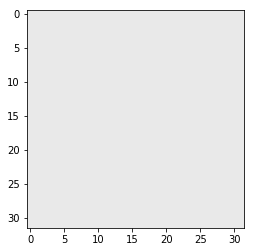

In [16]:
plt.imshow(all_patches_list[220,0])

In [17]:
ids[220]

'D:\\data\\POETdataset\\PascalImages\\aeroplane_2010_000091.jpg'

In [18]:
all_patches_list[220,1].min(), all_patches_list[221,2].max()

(233, 30)

In [19]:
np.save('all_labels_list', all_labels_list)

In [20]:
np.save('all_patches_list', all_patches_list)

In [21]:
np.save('all_patches_ids', ids)